In [1]:
from tensorflow import keras
keras.__version__

'2.2.4-tf'

In [2]:
import tensorflow as tf   #tf 2.0 GPU error 해결법
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)

sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

# 영화 리뷰 분류: 이진 분류 예제

이 노트북은 [케라스 창시자에게 배우는 딥러닝](https://tensorflow.blog/케라스-창시자에게-배우는-딥러닝/) 책의 3장 4절의 코드 예제입니다. 책에는 더 많은 내용과 그림이 있습니다. 이 노트북에는 소스 코드에 관련된 설명만 포함합니다. 이 노트북의 설명은 케라스 버전 2.2.2에 맞추어져 있습니다. 케라스 최신 버전이 릴리스되면 노트북을 다시 테스트하기 때문에 설명과 코드의 결과가 조금 다를 수 있습니다.

----

2종 분류 또는 이진 분류는 아마도 가장 널리 적용된 머신 러닝 문제일 것입니다. 이 예제에서 리뷰 텍스트를 기반으로 영화 리뷰를 긍정과 부정로 분류하는 법을 배우겠습니다.

## IMDB 데이터셋

인터넷 영화 데이터베이스로부터 가져온 양극단의 리뷰 50,000개로 이루어진 IMDB 데이터셋을 사용하겠습니다. 이 데이터셋은 훈련 데이터 25,000개와 테스트 데이터 25,000개로 나뉘어 있고 각각 50%는 부정, 50%는 긍정 리뷰로 구성되어 있습니다.

왜 훈련 데이터와 테스트 데이터를 나눌까요? 같은 데이터에서 머신 러닝 모델을 훈련하고 테스트해서는 절대 안 되기 때문입니다! 모델이 훈련 데이터에서 잘 작동한다는 것이 처음 만난 데이터에서도 잘 동작한다는 것을 보장하지 않습니다. 중요한 것은 새로운 데이터에 대한 모델의 성능입니다(사실 훈련 데이터의 레이블은 이미 알고 있기 때문에 이를 예측하는 모델은 필요하지 않습니다). 예를 들어 모델이 훈련 샘플과 타깃 사이의 매핑을 모두 외워버릴 수 있습니다. 이런 모델은 처음 만나는 데이터에서 타깃을 예측하는 작업에는 쓸모가 없습니다. 다음 장에서 이에 대해 더 자세히 살펴보겠습니다.

MNIST 데이터셋처럼 IMDB 데이터셋도 케라스에 포함되어 있습니다. 이 데이터는 전처리되어 있어 각 리뷰(단어 시퀀스)가 숫자 시퀀스로 변환되어 있습니다. 여기서 각 숫자는 사전에 있는 고유한 단어를 나타냅니다.

다음 코드는 데이터셋을 로드합니다(처음 실행하면 17MB 정도의 데이터가 컴퓨터에 다운로드됩니다):

In [3]:
from tensorflow.keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

매개변수 `num_words=10000`은 훈련 데이터에서 가장 자주 나타나는 단어 10,000개만 사용하겠다는 의미입니다. 드물게 나타나는 단어는 무시하겠습니다. 이렇게 하면 적절한 크기의 벡터 데이터를 얻을 수 있습니다.

변수 `train_data`와 `test_data`는 리뷰의 목록입니다. 각 리뷰는 단어 인덱스의 리스트입니다(단어 시퀀스가 인코딩된 것입니다). `train_labels`와 `test_labels`는 부정을 나타내는 0과 긍정을 나타내는 1의 리스트입니다:

In [4]:
train_data[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 5535,
 18,

In [5]:
train_labels[0]

1

가장 자주 등장하는 단어 10,000개로 제한했기 때문에 단어 인덱스는 10,000을 넘지 않습니다:

In [6]:
max([max(sequence) for sequence in train_data])

9999

재미 삼아 이 리뷰 데이터 하나를 원래 영어 단어로 어떻게 바꾸는지 보겠습니다:

In [7]:
# word_index는 단어와 정수 인덱스를 매핑한 딕셔너리입니다
word_index = imdb.get_word_index()
# 정수 인덱스와 단어를 매핑하도록 뒤집습니다
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# 리뷰를 디코딩합니다. 
# 0, 1, 2는 '패딩', '문서 시작', '사전에 없음'을 위한 인덱스이므로 3을 뺍니다
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

In [8]:
decoded_review

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

## 데이터 준비

신경망에 숫자 리스트를 주입할 수는 없습니다. 리스트를 텐서로 바꾸는 두 가지 방법이 있습니다:

* 같은 길이가 되도록 리스트에 패딩을 추가하고 `(samples, sequence_length)` 크기의 정수 텐서로 변환합니다. 그다음 이 정수 텐서를 다룰 수 있는 층을 신경망의 첫 번째 층으로 사용합니다(`Embedding` 층을 말하며 나중에 자세히 다루겠습니다).
* 리스트를 원-핫 인코딩하여 0과 1의 벡터로 변환합니다. 예를 들면 시퀀스 `[3, 5]`를 인덱스 3과 5의 위치는 1이고 그 외는 모두 0인 10,000차원의 벡터로 각각 변환합니다. 그다음 부동 소수 벡터 데이터를 다룰 수 있는 `Dense` 층을 신경망의 첫 번째 층으로 사용합니다.

여기서는 두 번째 방식을 사용하고 이해를 돕기 위해 직접 데이터를 원-핫 벡터로 만들겠습니다:

In [9]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    # 크기가 (len(sequences), dimension))이고 모든 원소가 0인 행렬을 만듭니다
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # results[i]에서 특정 인덱스의 위치를 1로 만듭니다
    return results

# 훈련 데이터를 벡터로 변환합니다
x_train = vectorize_sequences(train_data)
# 테스트 데이터를 벡터로 변환합니다
x_test = vectorize_sequences(test_data)

이제 샘플은 다음과 같이 나타납니다:

In [10]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

레이블은 쉽게 벡터로 바꿀 수 있습니다:

In [11]:
# 레이블을 벡터로 바꿉니다
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

이제 신경망에 주입할 데이터가 준비되었습니다.

## 신경망 모델 만들기

입력 데이터가 벡터이고 레이블은 스칼라(1 또는 0)입니다. 아마 앞으로 볼 수 있는 문제 중에서 가장 간단할 것입니다. 이런 문제에 잘 작동하는 네트워크 종류는 `relu` 활성화 함수를 사용한 완전 연결 층(즉, `Dense(16, activation='relu')`)을 그냥 쌓은 것입니다.

`Dense` 층에 전달한 매개변수(16)는 은닉 유닛의 개수입니다. 하나의 은닉 유닛은 층이 나타내는 표현 공간에서 하나의 차원이 됩니다. 2장에서 `relu` 활성화 함수를 사용한 `Dense` 층을 다음과 같은 텐서 연산을 연결하여 구현하였습니다:

`output = relu(dot(W, input) + b)`

16개의 은닉 유닛이 있다는 것은 가중치 행렬 `W`의 크기가 `(input_dimension, 16)`이라는 뜻입니다. 입력 데이터와 `W`를 점곱하면 입력 데이터가 16 차원으로 표현된 공간으로 투영됩니다(그리고 편향 벡터 `b`를 더하고 `relu` 연산을 적용합니다). 표현 공간의 차원을 '신경망이 내재된 표현을 학습할 때 가질 수 있는 자유도'로 이해할 수 있습니다. 은닉 유닛을 늘리면 (표현 공간을 더 고차원으로 만들면) 신경망이 더욱 복잡한 표현을 학습할 수 있지만 계산 비용이 커지고 원치 않은 패턴을 학습할 수도 있습니다(훈련 데이터에서는 성능이 향상되지만 테스트 데이터에서는 그렇지 않은 패턴입니다).

`Dense` 층을 쌓을 때 두 가진 중요한 구조상의 결정이 필요합니다:

* 얼마나 많은 층을 사용할 것인가
* 각 층에 얼마나 많은 은닉 유닛을 둘 것인가

4장에서 이런 결정을 하는 데 도움이 되는 일반적인 원리를 배우겠습니다. 당분간은 저를 믿고 선택한 다음 구조를 따라 주세요.

* 16개의 은닉 유닛을 가진 두 개의 은닉층
* 현재 리뷰의 감정을 스칼라 값의 예측으로 출력하는 세 번째 층

중간에 있는 은닉층은 활성화 함수로 `relu`를 사용하고 마지막 층은 확률(0과 1 사이의 점수로, 어떤 샘플이 타깃 '1'일 가능성이 높다는 것은 그 리뷰가 긍정일 가능성이 높다는 것을 의미합니다)을 출력하기 위해 시그모이드 활성화 함수를 사용합니다. `relu`는 음수를 0으로 만드는 함수입니다. 시그모이드는 임의의 값을 [0, 1] 사이로 압축하므로 출력 값을 확률처럼 해석할 수 있습니다.

다음이 이 신경망의 모습입니다:

![3-layer network](https://s3.amazonaws.com/book.keras.io/img/ch3/3_layer_network.png)

다음은 이 신경망의 케라스 구현입니다. 이전에 보았던 MNIST 예제와 비슷합니다:

In [12]:
from tensorflow.keras import models, layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

마지막으로 손실 함수와 옵티마이저를 선택해야 합니다. 이진 분류 문제이고 신경망의 출력이 확률이기 때문에(네트워크의 끝에 시그모이드 활성화 함수를 사용한 하나의 유닛으로 된 층을 놓았습니다), `binary_crossentropy` 손실이 적합합니다. 이 함수가 유일한 선택은 아니고 예를 들어 `mean_squared_error`를 사용할 수도 있습니다. 확률을 출력하는 모델을 사용할 때는 크로스엔트로피가 최선의 선택입니다. 크로스엔트로피는 정보 이론 분야에서 온 개념으로 확률 분포 간의 차이를 측정합니다. 여기에서는 원본 분포와 예측 분포 사이를 측정합니다.

다음은 `rmsprop` 옵티마이저와 `binary_crossentropy` 손실 함수로 모델을 설정하는 단계입니다. 훈련하는 동안 정확도를 사용해 모니터링하겠습니다.

In [13]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

케라스에 `rmsprop`, `binary_crossentropy`, `accuracy`가 포함되어 있기 때문에 옵티마이저, 손실 함수, 측정 지표를 문자열로 지정하는 것이 가능합니다. 이따금 옵티마이저의 매개변수를 바꾸거나 자신만의 손실 함수, 측정 함수를 전달해야 할 경우가 있습니다. 전자의 경우에는 옵티마이저 파이썬 클래스를 사용해 객체를 직접 만들어 `optimizer` 매개변수에 전달하면 됩니다:

In [14]:
from tensorflow.keras import optimizers

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

후자의 경우는 `loss`와 `metrics` 매개변수에 함수 객체를 전달하면 됩니다:

In [15]:
from tensorflow.keras import losses, metrics

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])

In [16]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

## 훈련 검증

훈련하는 동안 처음 본 데이터에 대한 모델의 정확도를 측정하기 위해서는 원본 훈련 데이터에서 10,000의 샘플을 떼어서 검증 세트를 만들어야 합니다:

In [17]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

이제 모델을 512개 샘플씩 미니 배치를 만들어 20번의 에포크 동안 훈련시킵니다(`x_train`과 `y_train` 텐서에 있는 모든 샘플에 대해 20번 반복합니다). 동시에 따로 떼어 놓은 10,000개의 샘플에서 손실과 정확도를 측정할 것입니다. 이렇게 하려면 `validation_data` 매개변수에 검증 데이터를 전달해야 합니다:

In [18]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 2s 151us/sample - loss: 0.5145 - accuracy: 0.7872 - val_loss: 0.3909 - val_accuracy: 0.8630
Epoch 2/20
15000/15000 [==============================] - 2s 108us/sample - loss: 0.3044 - accuracy: 0.9038 - val_loss: 0.3029 - val_accuracy: 0.8860
Epoch 3/20
15000/15000 [==============================] - 2s 109us/sample - loss: 0.2249 - accuracy: 0.9257 - val_loss: 0.2782 - val_accuracy: 0.8902
Epoch 4/20
15000/15000 [==============================] - 2s 112us/sample - loss: 0.1776 - accuracy: 0.9406 - val_loss: 0.2792 - val_accuracy: 0.8879
Epoch 5/20
15000/15000 [==============================] - 2s 116us/sample - loss: 0.1409 - accuracy: 0.9545 - val_loss: 0.2821 - val_accuracy: 0.8880
Epoch 6/20
15000/15000 [==============================] - 2s 109us/sample - loss: 0.1173 - accuracy: 0.9640 - val_loss: 0.2936 - val_accuracy: 0.8847
Epoch 7/20
15000/15000 [==========================

CPU를 사용해도 에포크마다 2초가 걸리지 않습니다. 전체 훈련은 20초 이상 걸립니다. 에포크가 끝날 때마다 10,000개의 검증 샘플 데이터에서 손실과 정확도를 계산하기 때문에 약간씩 지연됩니다.

`model.fit()` 메서드는 `History` 객체를 반환합니다. 이 객체는 훈련하는 동안 발생한 모든 정보를 담고 있는 딕셔너리인 `history` 속성을 가지고 있습니다. 한 번 확인해 보죠:

In [19]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

이 딕셔너리는 훈련과 검증하는 동안 모니터링할 측정 지표당 하나씩 모두 네 개의 항목을 담고 있습니다. 맷플롯립을 사용해 훈련과 검증 데이터에 대한 손실과 정확도를 그려 보겠습니다:

In [20]:
import matplotlib.pyplot as plt

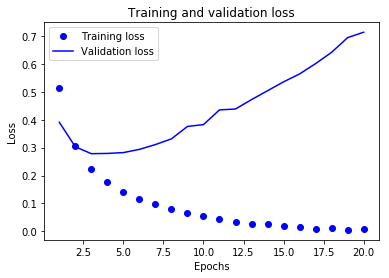

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# ‘bo’는 파란색 점을 의미합니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# ‘b’는 파란색 실선을 의미합니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

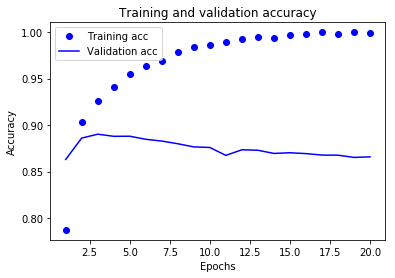

In [22]:
plt.clf()   # 그래프를 초기화합니다
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

점선은 훈련 손실과 정확도이고 실선은 검증 손실과 정확도입니다. 신경망의 무작위한 초기화 때문에 사람마다 결과거 조금 다를 수 있습니다.

여기에서 볼 수 있듯이 훈련 손실이 에포크마다 감소하고 훈련 정확도는 에포크마다 증가합니다. 경사 하강법 최적화를 사용했을 때 반복마다 최소화되는 것이 손실이므로 기대했던 대로입니다. 검증 손실과 정확도는 이와 같지 않습니다. 4번째 에포크에서 그래프가 역전되는 것 같습니다. 이것이 훈련 세트에서 잘 작동하는 모델이 처음 보는 데이터에 잘 작동하지 않을 수 있다고 앞서 언급한 경고의 한 사례입니다. 정확한 용어로 말하면 과대적합되었다고 합니다. 2번째 에포크 이후부터 훈련 데이터에 과도하게 최적화되어 훈련 데이터에 특화된 표현을 학습하므로 훈련 세트 이외의 데이터에는 일반화되지 못합니다.

이런 경우에 과대적합을 방지하기 위해서 3번째 에포크 이후에 훈련을 중지할 수 있습니다. 일반적으로 4장에서 보게 될 과대적합을 완화하는 다양한 종류의 기술을 사용할 수 있습니다.

처음부터 다시 새로운 신경망을 4번의 에포크 동안만 훈련하고 테스트 데이터에서 평가해 보겠습니다:

In [23]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/4
25000/25000 [==============================] - 2s 71us/sample - loss: 0.4375 - accuracy: 0.8254
Epoch 2/4
25000/25000 [==============================] - 2s 66us/sample - loss: 0.2568 - accuracy: 0.9112
Epoch 3/4
25000/25000 [==============================] - 2s 66us/sample - loss: 0.2002 - accuracy: 0.9288s - loss: 0.1985 - accuracy: 0.
Epoch 4/4
25000/25000 [==============================] - 3s 117us/sample - loss: 0.2903 - accuracy: 0.8855


In [24]:
results

[0.2903355294036865, 0.88548]

아주 단순한 방식으로도 87%의 정확도를 달성했습니다. 최고 수준의 기법을 사용하면 95%에 가까운 성능을 얻을 수 있습니다.

## 훈련된 모델로 새로운 데이터에 대해 예측하기

모델을 훈련시킨 후에 이를 실전 환경에서 사용하고 싶을 것입니다. `predict` 메서드를 사용해서 어떤 리뷰가 긍정일 확률을 예측할 수 있습니다:

In [25]:
model.predict(x_test)

array([[0.24220216],
       [0.9991312 ],
       [0.9510017 ],
       ...,
       [0.11338219],
       [0.07455266],
       [0.51968443]], dtype=float32)

여기에서처럼 이 모델은 어떤 샘플에 대해 확신을 가지고 있지만(0.99 또는 그 이상, 0.01 또는 그 이하) 어떤 샘플에 대해서는 확신이 부족합니다(0.6, 0.4). 

## 추가 실험

* 여기에서는 두 개의 은닉층을 사용했습니다. 한 개 또는 세 개의 은닉층을 사용하고 검증과 테스트 정확도에 어떤 영향을 미치는지 확인해 보세요.
* 층의 은닉 유닛을 추가하거나 줄여 보세요: 32개 유닛, 64개 유닛 등
* `binary_crossentropy` 대신에 `mse` 손실 함수를 사용해 보세요.
* `relu` 대신에 `tanh` 활성화 함수(초창기 신경망에서 인기 있었던 함수입니다)를 사용해 보세요.

다음 실험을 진행하면 여기에서 선택한 구조가 향상의 여지는 있지만 어느 정도 납득할 만한 수준이라는 것을 알게 것입니다!

## 정리

다음은 이 예제에서 배운 것들입니다:

* 원본 데이터를 신경망에 텐서로 주입하기 위해서는 꽤 많은 전처리가 필요합니다. 단어 시퀀스는 이진 벡터로 인코딩될 수 있고 다른 인코딩 방식도 있습니다.
* `relu` 활성화 함수와 함께 `Dense` 층을 쌓은 네트워크는 (감성 분류를 포함하여) 여러 종류의 문제에 적용할 수 있어서 앞으로 자주 사용하게 될 것입니다.
* (출력 클래스가 두 개인) 이진 분류 문제에서 네트워크는 하나의 유닛과 `sigmoid` 활성화 함수를 가진 `Dense` 층으로 끝나야 합니다. 이 신경망의 출력은 확률을 나타내는 0과 1 사이의 스칼라 값입니다.
* 이진 분류 문제에서 이런 스칼라 시그모이드 출력에 대해 사용할 손실 함수는 `binary_crossentropy`입니다.
* `rmsprop` 옵티마이저는 문제에 상관없이 일반적으로 충분히 좋은 선택입니다. 걱정할 거리가 하나 줄은 셈입니다.
* 훈련 데이터에 대해 성능이 향상됨에 따라 신경망은 과대적합되기 시작하고 이전에 본적 없는 데이터에서는 결과가 점점 나빠지게 됩니다. 항상 훈련 세트 이외의 데이터에서 성능을 모니터링해야 합니다.